Using the seed 1481769865


  0%|          | 0/20 [00:00<?, ?it/s]

masterpiece, high quality, 1boy, solo, male_focus, (handsome blond naval captain), low ponytail, indigo naval uniform, epaulettes, waistcoat, cravat, bishounen, blurry foreground, backlighting, dark blue military jacket, painterly by john singer sargent, soft cinematic lighting, dynamic pose, underwater


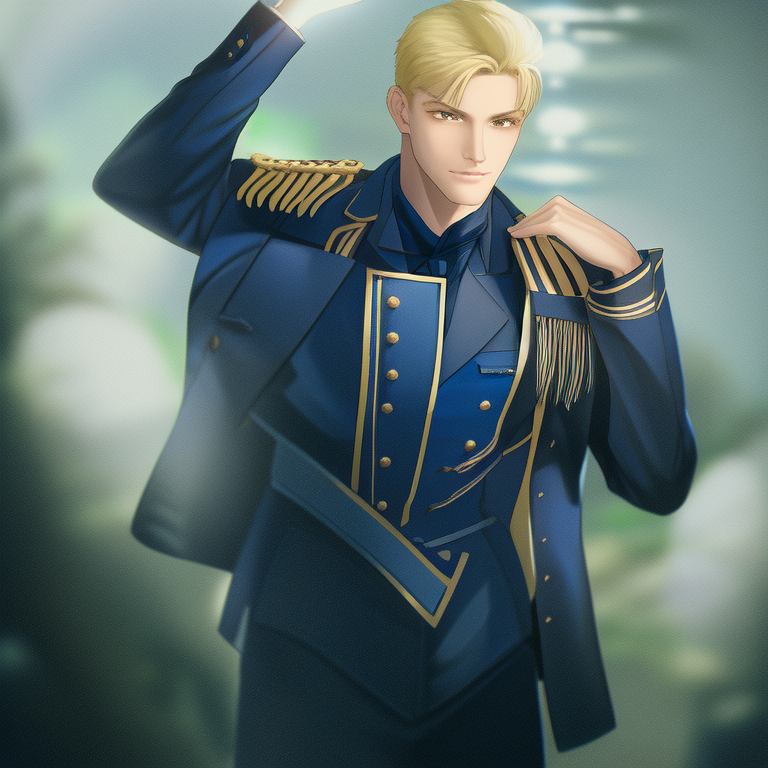

In [5]:
#install

# If you know what you're doing and want to connect this cell to Google Drive, 
# uncomment the following lines and fill in the google drive folders you want to
# connect to!

# from google.colab import drive
# drive.mount('/content/gdrive')

# outputs_folder = "/content/gdrive/MyDrive/AI/StableDiffusion" #@param{type: 'string'}
# custom_models_folder = "/content/gdrive/MyDrive/AI/StableDiffusion/models" #@param{type: 'string'}
# custom_embeddings_folder = "/content/gdrive/MyDrive/AI/StableDiffusion/embeddings" #@param{type: 'string'}
# custom_randomizer_folder = "/content/gdrive/MyDrive/AI/StableDiffusion/randomizers" #@param{type: 'string'}

# to load a custom model, uncomment the two lines below and put in the name of the model
# without the extension - so if the file is "catdiffusion.ckpt", put in "catdiffusion"
# this will override the selection you have for the model choice

# custom_model = insert_name_of_model_here #@param{type: 'string'} 
# use_custom_model = True #@param{type: 'boolean'}

#@markdown
#@markdown If the code to the left is too large or annoying, double click on this text to hide it<br/>See above cell for model descriptions and settings explanation <br />
#@markdown ### <b>Model Choice </b>
model = "Stable Diffusion 1.5" #@param ['Stable Diffusion 1.4', 'Stable Diffusion 1.5', 'Stable Diffusion 2.0 (512)', 'Stable Diffusion 2.0 (768)', 'Stable Diffusion 2.1 (512)', 'Stable Diffusion 2.1 (768)', 'Dreamlike Diffusion', 'Openjourney', 'Openjourney V2 Beta', 'seek.art_MEGA', 'Sygil Diffusion', 'Analog Diffusion', 'Dreamlike Photoreal', 'Anything v3.0', 'Anything v4.0', 'Waifu Diffusion 1.3', 'Waifu Diffusion 1.4', 'Waifu Diffusion 1.5 Beta (768)', 'Plat Diffusion (Waifu 1.4 finetune)', 'Pastel Waifu Diffusion', 'Inkpunk Diffusion', 'Vivid Watercolors', 'Future Diffusion', 'Gigafractal Diffusion (768)', 'Van Gogh Diffusion', 'Modern Art Style', 'Corporate Memphis', 'Pokemon Diffusion', 'Robo Diffusion', 'Classic Animation Diffusion', 'Modern Animation Diffusion', 'Ghibli Diffusion', 'Furry Diffusion'] {type:"string"}

add_automatic_keyword = True #@param {type: "boolean"}
download_a_collection_of_text_inversion_embeddings_and_load_them = False #@param {type: "boolean"}
#@markdown

#@markdown ### <b>Image Generation</b><br>
#@markdown See previous cell for setting explanations
prompt = "(the land of the frogs, <_style>, painted by zdzislaw beksinski:1), (a beautiful <_color> landscape:0.5)" #@param{type:"string"}
negative = "" #@param{type: 'string'}
resolution = "Square 512x512 (default, good for most models)" #@param ["Custom (Select this and put width and height below)", "Square 512x512 (default, good for most models)", "Landscape 768x512", "Portrait 512x768", "Square 768x768 (good for 768 models)", "Landscape 1152x768 (does not work on free colab)", "Portrait 768x1152 (does not work on free colab)"] {type:"string"}


#width_height = [768,512] #@param{type: 'raw'}
#@markdown <br>
#@markdown <b>Advanced Settings</b>
width_height_if_custom_is_selected = [768, 768] #@param{type: 'raw'}
steps = 20 #@param {type:"integer"}
samples_per_batch = 1
number_of_images = 1 #@param {type:"integer"}
seed = -1 #@param {type:"integer"}
sampler = "Euler a" #@param ["Euler a", "Euler", "KLMS", "DPMSolver++ (2S) (has issues with img2img)", "DPMSolver++ (2M)"] {type:"string"}
guidance_scale = 7 #@param {type:"slider", min:0, max:20, step:0.5}
ddim_eta = 0.0
zoom = False
tiling = False #@param {type: "boolean"}
#@markdown If `tiling` results look poor, double the amount of steps from non-tiling.
#@markdown <br>
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>img2img</b><br>
init_image_or_folder = "" #@param {type:"string"}
img2img_strength = 0.5 #@param {type:"slider", min:0.1, max:1.0, step:0.05}
#@markdown Lower img2img strength means the image is changed less, while higher img2img strength means the image is changed more
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>Upscaling</b><br>

upscale_results = False #@param {type: 'boolean'}
# detailing = 1 #@param {type:"slider", min:1, max:4, step:1}
upscale_strength = 0.2 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
######

should_load_downloaded_embeds = False
test_mode = True
enable_attention_slicing = False
enable_xformers = False
%env PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128

try:
  import torch
  import src
  %cd /content/simplest-stable/
except ImportError as e:
  import os, subprocess
  %cd /content/
  subprocess.run(["git", "clone", "https://github.com/cadaeix/simplest-stable.git"])
  %cd /content/simplest-stable/
  if test_mode:
    subprocess.run(["git", "checkout", "test-branch"])
  if enable_xformers:
    subprocess.run(['pip', 'install', 'triton==2.0.0.dev20221202', 'xformers==0.0.16rc424'])
  subprocess.run(["pip3", "install", "-r", "requirements.txt"])
  outputs_path = "/content/images/"
  subprocess.run(["mkdir", "-p", outputs_path])
  print(f"Outputs will be saved to {outputs_path}.")
  downloaded_embeds_path = None

import os, subprocess, sys, random, math, json, glob, logging
logging.disable(sys.maxsize)

# Pillow occasionally has odd import errors, the below fix them
import PIL.Image
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
  PIL.Image.Resampling = PIL.Image

import PIL._util
if not hasattr(PIL._util, 'is_path'):
  from pathlib import Path
  def is_path(f):
    return isinstance(f, (bytes, str, Path))
  PIL._util.is_path = is_path

import PIL.TiffTags
if not hasattr(PIL.TiffTags, 'IFD'):
  PIL.TiffTags.IFD = 13
if not hasattr(PIL.TiffTags, 'LONG8'):
  PIL.TiffTags.LONG8 = 16

from datetime import datetime
from src.loading import prepare_pipe, load_embeddings
from src.process import process_and_generate
from src.utils import free_ram, find_custom_models
from src.randomizer import get_default_random_lists_from_folder, get_random_lists_from_folder
from IPython.display import display, clear_output
sys.path.append(".")

if download_a_collection_of_text_inversion_embeddings_and_load_them:
  downloaded_embeds_path = "/content/embeds/"
  if not os.path.exists(downloaded_embeds_path):
    subprocess.run(["mkdir", "-p", downloaded_embeds_path])
    with open('src/resources/embeddings_links.json') as embeddingfile:
      embed_dict = json.load(embeddingfile)
    for embed in embed_dict["embeddings"]:
      subprocess.run(["wget", "-O", os.path.join(downloaded_embeds_path, embed["filename"]), embed["download_url"]])
  should_load_downloaded_embeds = True

try:
  outputs_folder
  if not os.path.exists(outputs_folder):
      os.mkdirs(outputs_folder)
  session_folder = outputs_folder
except NameError as e:
  outputs_path = "images/"
  if not os.path.exists(outputs_path):
      os.mkdir(outputs_path)
      
  session_folder = os.path.join(outputs_path, datetime.now().strftime("%Y_%m_%d"))
  if not os.path.exists(session_folder):
      os.mkdir(session_folder)

try:
  custom_embeddings_folder
  embeddings_path = custom_embeddings_folder if os.path.exists(custom_embeddings_folder) else None
except NameError as e:
  embeddings_path = None

default_randomizers = get_default_random_lists_from_folder(
    "src/resources/randomizers")

try: 
  custom_randomizer_folder
  if os.path.exists(custom_randomizer_folder):
    randomizers = get_random_lists_from_folder(custom_randomizer_folder)
    randomizers = {**default_randomizers, **randomizers}
  else:
    randomizers = default_randomizers
except NameError as e:
  randomizers = default_randomizers

model_type_mode = "Downloadable Models"
try:
  custom_models_folder
  custom_models_path = custom_models_folder if os.path.exists(custom_models_folder) else None
  custom_model
  use_custom_model
  if use_custom_model and os.path.exists(custom_model):
    model_type_mode = "Custom Models"
    model = custom_model
    custom_model_dict, _ = find_custom_models(custom_models_path)
except NameError as e:
  custom_models_path = None
  model_type_mode = "Downloadable Models"

clear_output(wait=False)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

try:
  model_dict
except NameError as e:
  with open('src/resources/models.json') as modelfile:
      model_dict = json.load(modelfile)
  del modelfile

res_dict = {"Square 512x512 (default, good for most models)": [512,512],
            "Landscape 768x512": [768,512],
            "Portrait 512x768": [512,768],
            "Square 768x768 (good for 768 models)": [768,768],
            "Landscape 1152x768 (does not work on free colab)": [1152,768],
            "Portrait 768x1152 (does not work on free colab)":[768,1152]}
width, height = width_height_if_custom_is_selected if resolution == "Custom (Select this and put width and height below)" else res_dict[resolution]

opt = {
    "model_name" : model,
    "eta" : 0.0,
    "steps" : steps,
    "init_img" : init_image_or_folder if init_image_or_folder != "" else None,
    "mask_image": None,
    "number_of_images": number_of_images,
    "prompt" : prompt,
    "negative" : negative,
    "sampler" : sampler,
    "tiling" : tiling,
    "scale" : guidance_scale,
    "seed" : seed,
    "strength" : img2img_strength if init_image_or_folder != "" else None, # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
    "H" : height - height % 64,
    "W" : width - width % 64,
    #upscale stuff
    "passes" : 1,
    "upscale": upscale_results,
    "upscale_strength" : upscale_strength,
    "detail_scale" : 10,
    "add_keyword": add_automatic_keyword,
    "prediction_type": model_dict[model]["prediction"],
    "keyword": model_dict[model]["keyword"],
    "outputs_folder": session_folder,
    "program_version": "Simple Stable 2.0 (Notebook, pre-release 20230129)"
    }

recreate = False
try:
  pipe
  recreate = model_name != opt["model_name"]
  if recreate:
    del pipe
    free_ram()
except NameError as e:
  pipe = None
  recreate = True

if recreate:
  try:
    pipe, pipe_info = prepare_pipe(
      model_name = model, 
      model_type = model_type_mode, 
      downloadable_model_dict = model_dict,
      custom_model_dict = None,
      cached_model_dict = None,
      enable_attention_slicing = enable_attention_slicing,
      enable_xformers = enable_xformers)
    opt["keyword"] = pipe_info["keyword"]
    opt["prediction_type"] = pipe_info["prediction_type"]
    if should_load_downloaded_embeds:
      pipe = load_embeddings(downloaded_embeds_path, pipe)
    if embeddings_path:
      pipe = load_embeddings(embeddings_path, pipe)
    model_name = opt["model_name"]
  except Exception as e:
    print(f"Failed to load selected model for some reason, please try loading another model. If that doesn't work, go to Runtime -> Disconnect and Delete Runtime and then rerun this cell, and then if that fails, take a screenshot or copy the error below and ask @Cadaeic about it!")
    raise e

try:
  pipe, images, images_details = process_and_generate(
    opt = opt,
    pipe = pipe, 
    progress=None,
    randomizer = randomizers,
    display_and_print=True
    )
except Exception as e:
  print(f"Generation of images failed for some reason, try loading another model. If that doesn't work, go to Runtime -> Disconnect and Delete Runtime and then rerun this cell, and then if that fails, take a screenshot or copy the error below and ask @Cadaeic about it!")
  raise e